In [60]:
import os
from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

### Load data stored during learning

In [61]:
base_path = "./"
perc_collisions = np.load(f"{base_path}perc_collisions.npy")
perc_offroad = np.load(f"{base_path}perc_offroad.npy")
perc_goal_achieved = np.load(f"{base_path}perc_goal_achieved.npy")
wallclock_time = np.load(f"{base_path}wallclock_time.npy")
global_steps = np.load(f"{base_path}global_steps.npy")

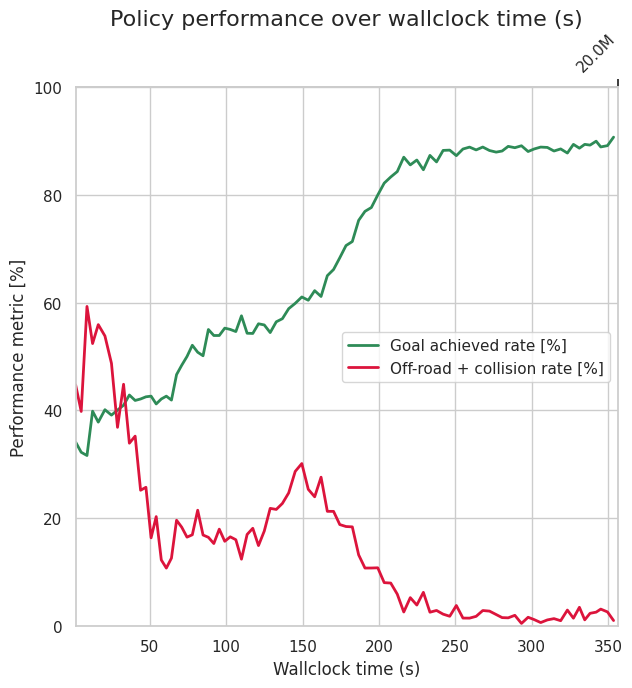

In [62]:
# Compute the combined collision rate
combined_collisions = (perc_collisions + perc_offroad) * 100 
perc_goal_achieved *= 100

# Set up Seaborn for styling
sns.set_theme(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.set_xlim(wallclock_time.min(), wallclock_time.max())
ax.set_ylim(-0.1, 100) 

ax.set_title("Policy performance over wallclock time (s)", fontsize=16, y=1.1)
ax.set_xlabel("Wallclock time (s)", fontsize=12)
ax.set_ylabel("Performance metric [%]", fontsize=12)

# Create secondary x-axis
ax2 = ax.secondary_xaxis('top')
#ax2.set_xlabel("Global Step", fontsize=12)

# Shorten global steps for display in thousands or millions
def format_global_steps(steps):
    formatted = []
    for step in steps:
        if step >= 1_000_000:
            formatted.append(f"{step / 1_000_000:.1f}M")  # Display in millions
        elif step >= 1_000:
            formatted.append(f"{step / 1_000:.1f}K")  # Display in thousands
        else:
            formatted.append(str(step))  # Display the number as is
    return formatted

formatted_global_steps = format_global_steps(global_steps)

# Initialize the lines for each metric
line_goal, = ax.plot([], [], color="seagreen", lw=2, label="Goal achieved rate [%]")
line_collision, = ax.plot([], [], color="crimson", lw=2, label="Off-road + collision rate [%]")

# Add a legend
ax.legend(loc="center right")

# Animation update function
def animate(i):
    # Update each line with the current data up to the ith frame
    line_goal.set_data(wallclock_time[:i], perc_goal_achieved[:i])
    line_collision.set_data(wallclock_time[:i], combined_collisions[:i])
    
    # Update secondary x-axis ticks to correspond with wallclock_time every 10 frames
    if i % 10 == 0:
        ax2.set_xticks([wallclock_time[i]])  # Set tick as a list
        ax2.set_xticklabels([formatted_global_steps[i]], rotation=45, ha="right")  # Set label as a list
    
    return line_goal, line_collision

# Create the animation
ani = animation.FuncAnimation(
    fig, 
    animate, 
    frames=len(wallclock_time),
    interval=50, 
    blit=True, 
    repeat=True
)

# Save the animation as a GIF
ani.save('learning_anim_11_01.gif', writer='pillow', fps=15, dpi=300)

# Display animation 
HTML(ani.to_jshtml())